# Guided Project: Detecting Pneumonia Using X-Ray Images with CNNs and Transfer Learning

In [12]:
import tarfile

def extract_tar_gz(file_path, output_path):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=output_path)

extract_tar_gz('xray_dataset.tar.gz', '.')

In this project we will build two deep learning models and train them on a dataset containing images of chest X-rays. The aim of this project is to train classifiers on the dataset that can accurately predict whether an X-ray indicates any signs of pneumonia or not.

The models could then be used for developing tools that could aid hospitals in accurately identifying whether a patient has a particular disease or not.

In [13]:
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input, applications, initializers
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
img_size = 256

train_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="training",
    seed=417)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size),
    validation_split=0.20,
    subset="validation",
    seed=417)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory='chest_xray/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=128,
    image_size=(img_size, img_size))

normalization_layer = layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda x, y: (normalization_layer(x), y))
validation_set_normalized = validation_set.map(lambda x, y: (normalization_layer(x), y))
test_set_normalized = test_set.map(lambda x, y: (normalization_layer(x), y))

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


In [15]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [16]:
train_set_elem = train_set.take(1)
for images, labels in train_set_elem:
    images = images.numpy()
    labels = labels.numpy()

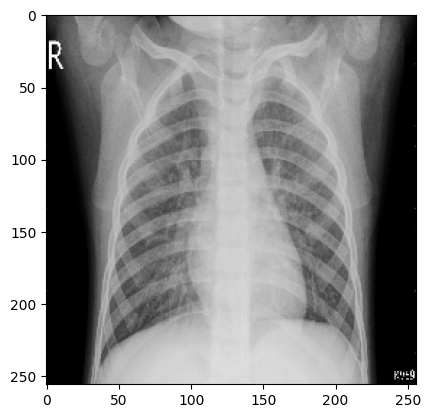

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [17]:
idx = 0
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Training Set Image Label: {labels[idx]}")
print(f"Training Set Image Shape: {images[idx].shape}")

In [18]:
test_set_elem = test_set.take(1)
for images, labels in test_set_elem:
    images = images.numpy()

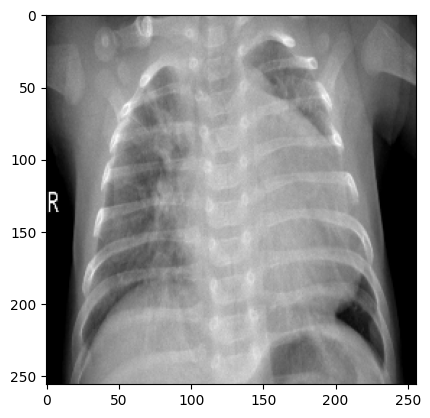

Test Set Image Label: [0. 1.]


In [19]:
idx = 16
plt.imshow(images[idx]/255.0)
plt.show()
print(f"Test Set Image Label: {labels[idx]}")

Note that the X-rays are not centred. Instead, the images are all rotated at different angles. Additionally, even though the images look to be in greyscale, they have 3 channels.
Also, t
The images don't seem to have a lot of informationandt, because of the overlap of ribs and lungs, it could be difficult to extract features specific to the infection. A more complex model could perhaps manage to extract relevant features.

Given the differences between how the X-rays were taken, the images could be rotated, at the very least, as part of data augmentation.

# Sequential CNN Model

In [20]:
first_model = models.Sequential()

first_model.add(layers.RandomZoom(height_factor=0.1))
first_model.add(layers.RandomRotation(factor=0.2))

first_model.add(layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', input_shape=(img_size, img_size, 3)))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))

first_model.add(layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu'))
first_model.add(layers.MaxPooling2D(pool_size=3, strides=2))
first_model.add(layers.Flatten())

first_model.add(layers.Dense(256, activation='relu'))
first_model.add(layers.Dropout(0.5))

first_model.add(layers.Dense(64, activation='relu'))
first_model.add(layers.Dropout(0.5))

first_model.add(layers.Dense(32, activation='relu'))
first_model.add(layers.Dropout(0.5))

first_model.add(layers.Dense(2))

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
first_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
first_model.build((None, img_size, img_size, 3))

first_model.summary()
first_model.fit(train_set_normalized, epochs=15, validation_data=validation_set_normalized, callbacks=[early_stopping_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_2 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 128)     3584      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 63, 63, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 31, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 256)      

Attempted to modify the model architecture a few times to reduce overfitting. This included:

- Using different combinations of data augmentation layer.
- Increasing the number of filters, with different sizes, strides.
- Changed the number of convolutional layers.
- Added more fully-connected layers.
- Removed batch normalisation layers after fully-connected layer and replaced them with dropout layers.
- Reducing the learning rate to help with model convergence.
- Added an early stopping callback to halt training if validation loss didn't increase for 3 consecutive epochs.
- Used the restore_best_weights argument to ensure the model uses weights from the epoch with the lowest validation loss only.

# Transfer Learning Model

In [22]:
base_model = applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

base_model.trainable = False

input_layer = Input(shape=(img_size, img_size, 3))

preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

features_layer = base_model(preprocessed_input_layer, training=False)

global_pooling = layers.GlobalAveragePooling2D()(features_layer)

fc1 = layers.Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)

fc2 = layers.Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)

fc3 = layers.Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

output = layers.Dense(2)(fc3)

second_model = Model(inputs=input_layer, outputs=output)

second_model.summary()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[early_stopping_callback])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 random_zoom_4 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                           

In [23]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable=False

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
second_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

second_model.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stopping_callback])

Epoch 1/5
33/33 [==============================] - 210s 6s/step - loss: 0.1072 - accuracy: 0.9575 - val_loss: 0.1310 - val_accuracy: 0.9484
Epoch 2/5
33/33 [==============================] - 206s 6s/step - loss: 0.0910 - accuracy: 0.9654 - val_loss: 0.1010 - val_accuracy: 0.9627
Epoch 3/5
33/33 [==============================] - 240s 7s/step - loss: 0.0842 - accuracy: 0.9699 - val_loss: 0.0941 - val_accuracy: 0.9637
Epoch 4/5
33/33 [==============================] - 207s 6s/step - loss: 0.0793 - accuracy: 0.9680 - val_loss: 0.1913 - val_accuracy: 0.9254
Epoch 5/5
33/33 [==============================] - 207s 6s/step - loss: 0.0819 - accuracy: 0.9692 - val_loss: 0.0932 - val_accuracy: 0.9704


The ResNet v2 architecture was selected since it was stated to be a better alternative to the original ResNet per the research paper.

Included the same data augmentation layers as the first model. Instead of flattening the layers, used a global pooling average layer followed by three fully-connected layers and an output layer.

Experimented with the number of layers to unfreeze for fine-tuning. Unfreezing layers beyond the last 10 either had diminishing returns or it worsened the model's performance.

The model doesn't seem to be overfitting given the added regularization and data augmentation, and the progression of the accuracy and loss values during training.

## Evaluating on the Test Set

In [24]:
first_model_test_loss, first_model_test_acc = first_model.evaluate(test_set_normalized)

print(f"Test set accuracy of first model: {first_model_test_acc}")

second_model_test_loss, second_model_test_acc = second_model.evaluate(test_set)

print(f"Test set accuracy of second model: {second_model_test_acc}")

5/5 [==============================] - 3s 430ms/step - loss: 0.3316 - accuracy: 0.8686
Test set accuracy of first model: 0.8685897588729858
5/5 [==============================] - 21s 4s/step - loss: 0.4003 - accuracy: 0.8622
Test set accuracy of second model: 0.8621794581413269


The second model, using transfer learning, outperforms the first model but not by a significant margin. The test set accuracies of both the models are not much lower than that their respective validation accuracies. That can be considered a good sign that the model probably isn't overfitting.

The accuracy of either of the models is not high enough to be suitable for a medical diagnosis. However, the second model with some more training and experimentation is likely to yield better performance given the lack of additional data.